In [ ]:
# CSCE A462
# Assignment 1
# Boro Zorigtbaatar

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [101]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.model_selection import train_test_split
from datetime import datetime

In [ ]:
# load dataset from Google Drive
file = "/content/drive/My Drive/SF_Street_Tree_List.csv"
tree_data = pd.read_csv(file)

# convert PlantDate to datetime
tree_data['PlantDate'] = pd.to_datetime(tree_data['PlantDate'], errors='coerce')

# extract year from PlantDate
tree_data['PlantYear'] = tree_data['PlantDate'].dt.year

# convert PlantDate to tree age in years
tree_data['TreeAgeYears'] = (datetime.now() - tree_data['PlantDate']).dt.days / 365.25
tree_data['TreeAgeYears'].fillna(tree_data['TreeAgeYears'].median(), inplace=True)

# normalize DBH values
tree_data = tree_data[(tree_data['DBH'] > 0) & (tree_data['DBH'] <= 100)]

# handle missing numerical values
numerical_features = ['DBH', 'Latitude', 'Longitude']
tree_data[numerical_features] = tree_data[numerical_features].fillna(tree_data[numerical_features].median())

species_encoded = pd.get_dummies(tree_data['qSpecies'].fillna('Unknown'))
caretaker_encoded = pd.get_dummies(tree_data['qCaretaker'].fillna('Unknown'))

# normalize numerical data
scaler = StandardScaler()
tree_data[['DBH', 'TreeAgeYears', 'Latitude', 'Longitude']] = scaler.fit_transform(tree_data[['DBH', 'TreeAgeYears', 'Latitude', 'Longitude']])


<ipython-input-102-4b2b786f20f3>:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  tree_data['PlantDate'] = pd.to_datetime(tree_data['PlantDate'], errors='coerce')
<ipython-input-102-4b2b786f20f3>:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  tree_data['TreeAgeYears'].fillna(tree_data['TreeAgeYears'].median(), inplace=True)
<ipython-input-102-4b2b786f20f3>:20: SettingWithCopyWarning: 
A

<ipython-input-103-82a4825f7bdf>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree_data['Neighborhoods (old)'] = tree_data['Neighborhoods (old)'].fillna(-1).astype(int)


,Neighborhoods (old),Tree Count,Neighborhood_Code,Neighborhood
15,15,13,15.0,Financial District
8,8,77,8.0,Russian Hill
30,30,85,30.0,Bernal Heights
18,18,177,18.0,West of Twin Peaks
14,14,717,14.0,Parkside
4,4,722,4.0,Inner Sunset
13,13,994,13.0,Excelsior
33,33,1230,33.0,Chinatown
36,36,1797,36.0,Western Addition
28,28,2029,28.0,Castro/Upper Market


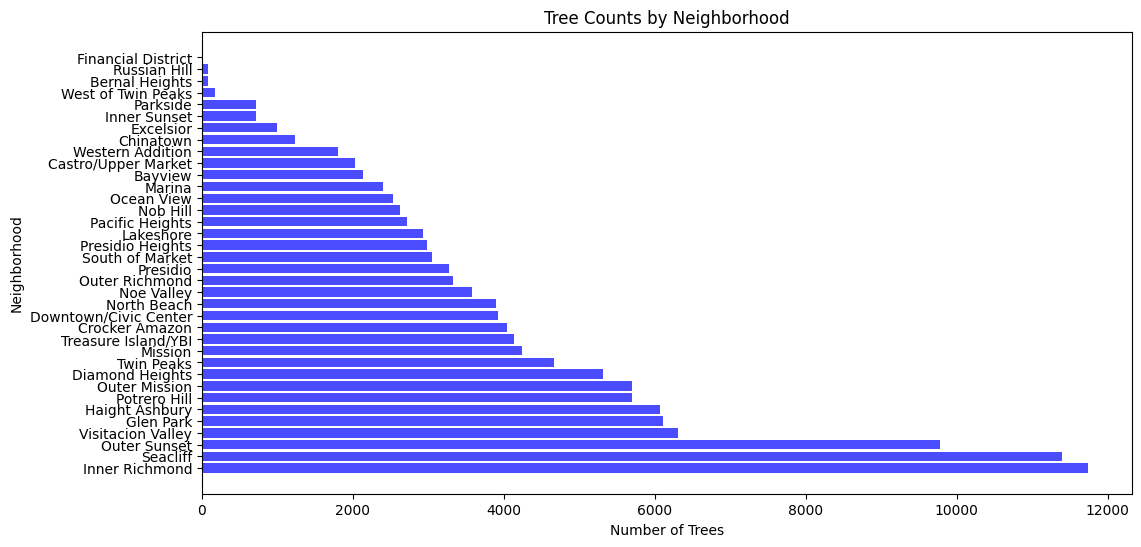

In [ ]:
neighbor_path = "/content/drive/My Drive/Neighborhood.csv"
neighbor = pd.read_csv(neighbor_path)

# clean the Neighborhood Data
neighbor.rename(columns={'neighborho': 'Neighborhood'}, inplace=True)

# assign a unique ID to each neighborhood
neighborhood_mapping_cleaned = neighbor.reset_index().rename(columns={'index': 'Neighborhood_Code'})
neighborhood_mapping_cleaned['Neighborhood_Code'] += 1  # Adjust index to match tree dataset codes

# remove missing and duplicate values
neighborhood_mapping_cleaned = neighborhood_mapping_cleaned.dropna(subset=['Neighborhood'])
neighborhood_mapping_cleaned = neighborhood_mapping_cleaned.drop_duplicates(subset=['Neighborhood'])

tree_data['Neighborhoods (old)'] = tree_data['Neighborhoods (old)'].fillna(-1).astype(int)

# count trees per neighborhood
tree_counts_corrected = tree_data.groupby('Neighborhoods (old)').size().reset_index(name='Tree Count')

tree_counts_corrected = tree_counts_corrected.merge(neighborhood_mapping_cleaned[['Neighborhood_Code', 'Neighborhood']], left_on='Neighborhoods (old)', right_on='Neighborhood_Code', how='left')

# drop any unmatched neighborhoods
tree_counts_corrected = tree_counts_corrected.dropna(subset=['Neighborhood'])

tree_counts_corrected_sorted = tree_counts_corrected.sort_values(by='Tree Count', ascending=True)

display(tree_counts_corrected_sorted)

plt.figure(figsize=(12, 6))
plt.barh(tree_counts_corrected_sorted['Neighborhood'], tree_counts_corrected_sorted['Tree Count'], color='blue', alpha=0.7)
plt.xlabel("Number of Trees")
plt.ylabel("Neighborhood")
plt.title("Tree Counts by Neighborhood")
plt.gca().invert_yaxis()
plt.show()

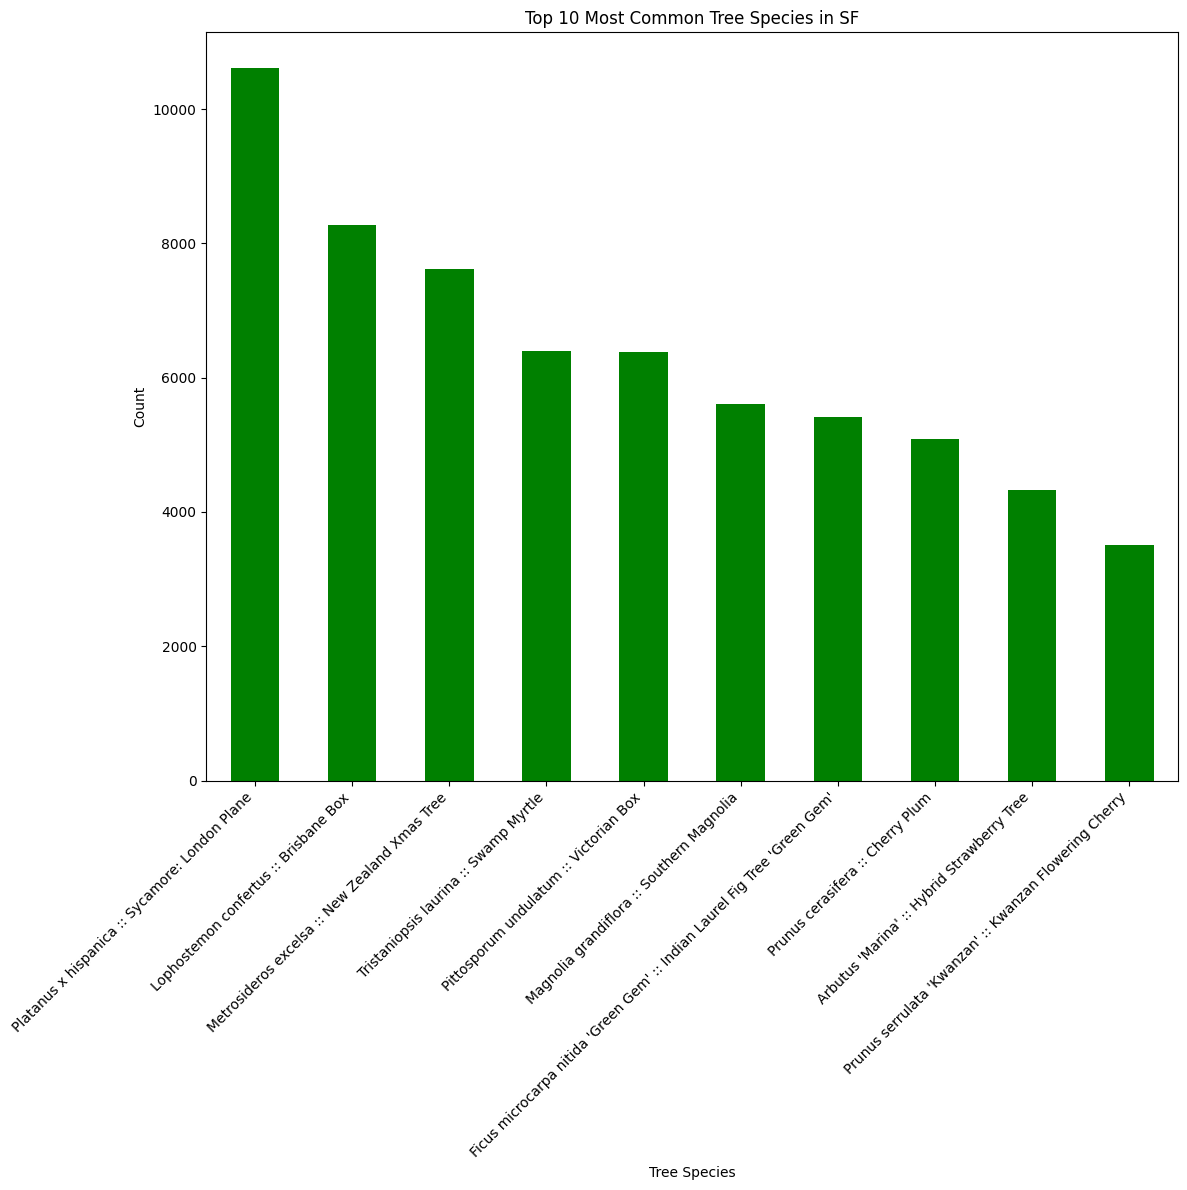

In [104]:
plt.figure(figsize=(12, 12))
tree_data['qSpecies'].value_counts().head(10).plot(kind='bar', color='green')
plt.xlabel('Tree Species')
plt.ylabel('Count')
plt.title('Top 10 Most Common Tree Species in SF')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

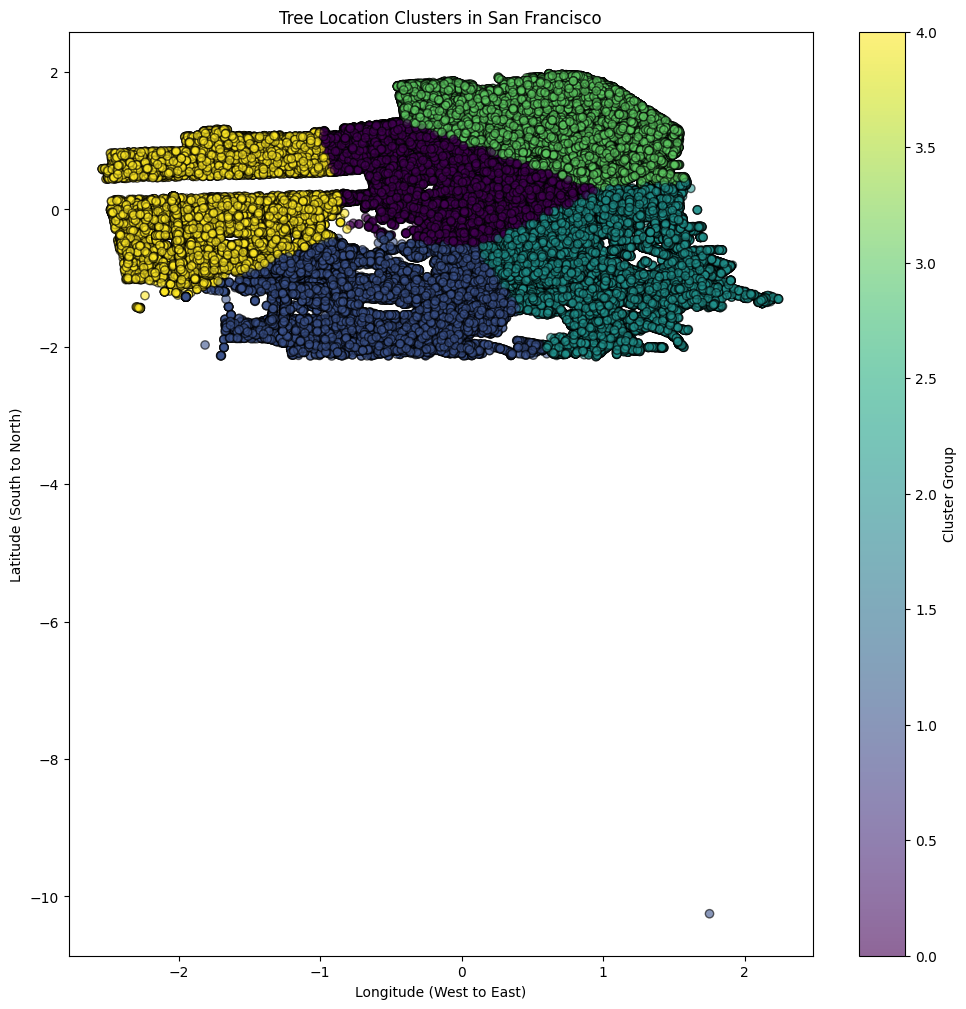

In [ ]:
X = tree_data[['Latitude', 'Longitude']]

# K-Means clustering
kmeans = KMeans(n_clusters=5, random_state=42)
tree_data['Cluster'] = kmeans.fit_predict(X)

plt.figure(figsize=(12, 12))
scatter = plt.scatter(tree_data['Longitude'], tree_data['Latitude'], c=tree_data['Cluster'], cmap='viridis', alpha=0.6, edgecolors='k')
plt.colorbar(scatter, label="Cluster Group")
plt.xlabel("Longitude (West to East)")
plt.ylabel("Latitude (South to North)")
plt.title("Tree Location Clusters in San Francisco")
plt.show()

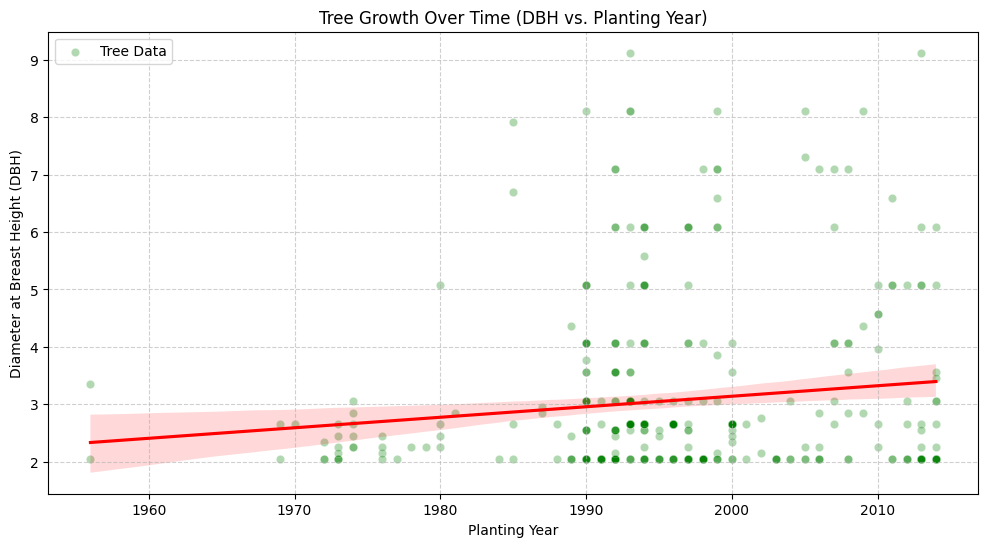

In [106]:
tree_data = tree_data[tree_data['PlantYear'] < 2015]
tree_data = tree_data[(tree_data['DBH'] > 2) & (tree_data['DBH'] <= 100)]

# IQR Filtering
Q1 = tree_data['DBH'].quantile(0.1)
Q3 = tree_data['DBH'].quantile(0.9)
IQR = Q3 - Q1
tree_data = tree_data[(tree_data['DBH'] >= (Q1 - 2.0 * IQR)) & (tree_data['DBH'] <= (Q3 + 2.0 * IQR))]

# Scatterplot: DBH vs. Plant Year
plt.figure(figsize=(12, 6))
sns.scatterplot(x=tree_data['PlantYear'], y=tree_data['DBH'], alpha=0.3, color="green", label="Tree Data")
sns.regplot(x=tree_data['PlantYear'], y=tree_data['DBH'], scatter=False, color="red", line_kws={"label": "Trendline (DBH Growth)"})
plt.xlabel('Planting Year')
plt.ylabel('Diameter at Breast Height (DBH)')
plt.title('Tree Growth Over Time (DBH vs. Planting Year)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


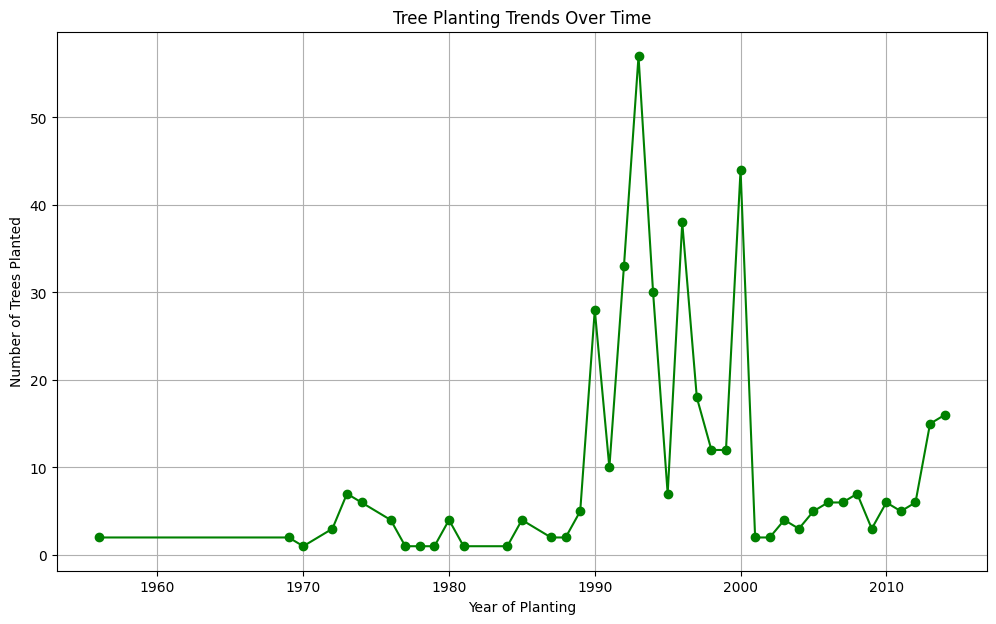

In [ ]:
# count trees by planting year
planting_trends = tree_data['PlantYear'].value_counts().sort_index()

plt.figure(figsize=(12, 7))
plt.plot(planting_trends.index, planting_trends.values, marker='o', linestyle='-', color='green', label='Tree Planting')
plt.xlabel('Year of Planting')
plt.ylabel('Number of Trees Planted')
plt.title('Tree Planting Trends Over Time')
plt.grid(True)
plt.show()

        Caretaker Type  Number of Trees
0                  DPW              177
1              Private              152
2                 Port               80
3             Rec/Park                8
4                SFUSD                3
5                  PUC                1
6  Dept of Real Estate                1


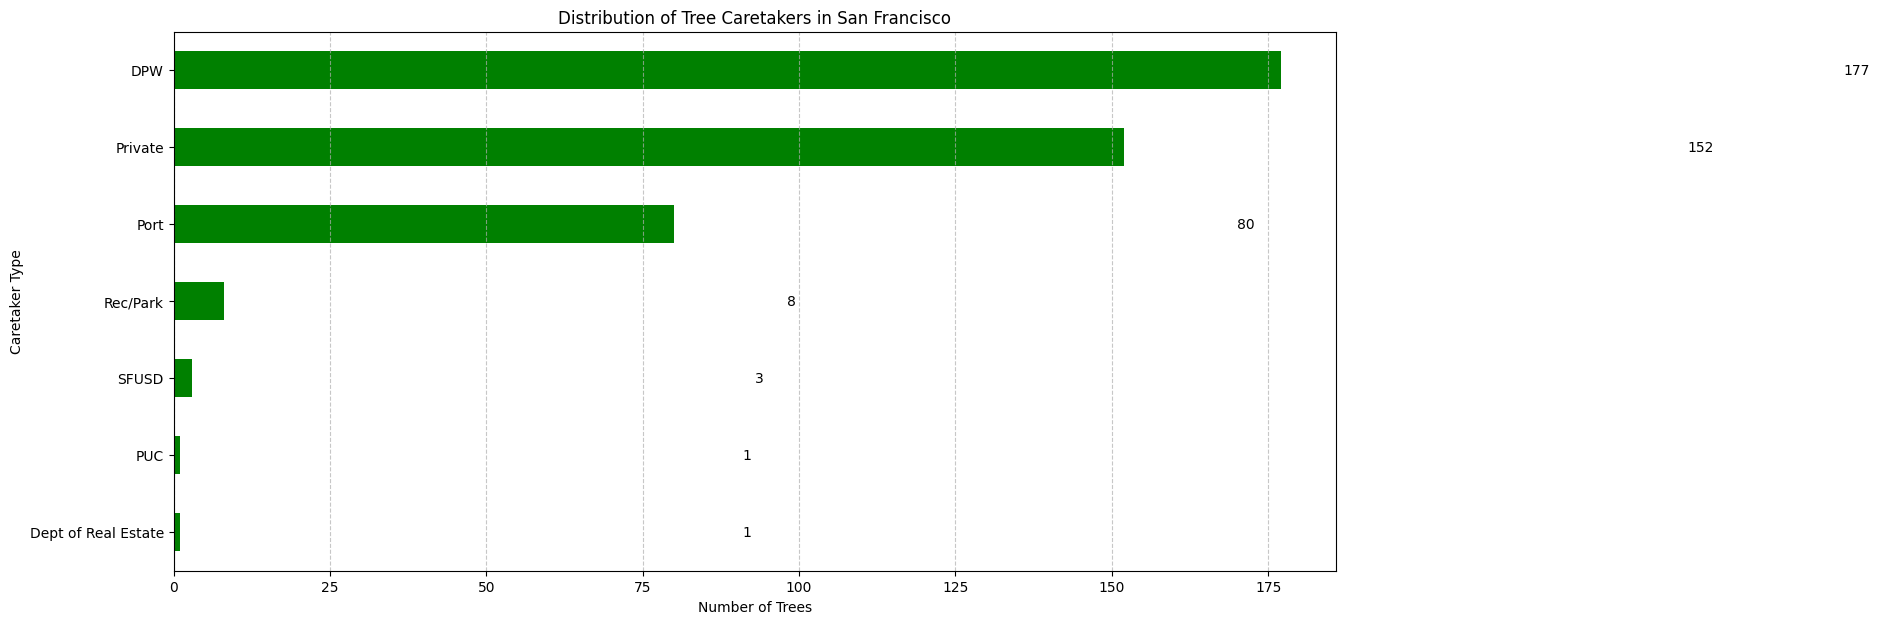

In [ ]:
caretaker_distribution = tree_data['qCaretaker'].value_counts()
caretaker_distribution_df = caretaker_distribution.reset_index()
caretaker_distribution_df.columns = ['Caretaker Type', 'Number of Trees']

# display table
print(caretaker_distribution_df)

plt.figure(figsize=(15, 7))
ax = caretaker_distribution.sort_values(ascending=True).plot(kind='barh', color='green')
for index, value in enumerate(caretaker_distribution.sort_values(ascending=True)):
    plt.text(value + 90, index, str(value), va='center', fontsize=10, color='black')
plt.xlabel('Number of Trees')
plt.ylabel('Caretaker Type')
plt.title('Distribution of Tree Caretakers in San Francisco')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()


In [109]:
!pip install tensorflow

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as t


 Future Tree Planting Predictions:
   Year  Polynomial Regression  Exponential Smoothing  LSTM (Neural Network)
0  2015             -45.350662              11.975701              18.843023
1  2016             -52.852989              12.041754              31.829594
2  2017             -60.867776              12.103973              34.010929
3  2018             -69.409718              12.162579              29.492290
4  2019             -78.493532              12.217783              32.962910
5  2020             -88.133957              12.269782              36.655102
6  2021             -98.345752              12.318762              31.549603
7  2022            -109.143697              12.364898              30.387236
8  2023            -120.542594              12.408356              35.930210
9  2024            -132.557266              12.449291              34.516663


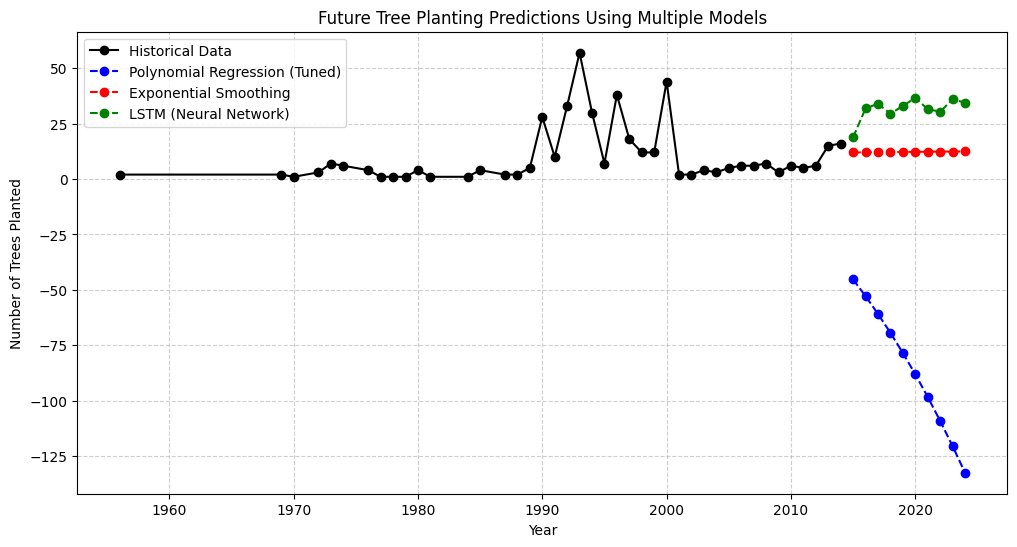

In [ ]:
# convert PlantDate to datetime and extract year
tree_data['PlantDate'] = pd.to_datetime(tree_data['PlantDate'], errors='coerce')
tree_data['PlantYear'] = tree_data['PlantDate'].dt.year

planting_trends = tree_data.groupby('PlantYear').size()

# convert to DataFrame
planting_trends_df = planting_trends.reset_index()
planting_trends_df.columns = ['Year', 'Trees Planted']

# data training
X = planting_trends_df[['Year']]
y = planting_trends_df['Trees Planted']

# split into train-test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# define forecast range (next 10 years)
forecast_years = 10
future_years = list(range(int(df['PlantYear'].max()) + 1, int(df['PlantYear'].max()) + 1 + forecast_years))
future_X = pd.DataFrame({'Year': future_years})

# Polynomial Regression (Tuned)
poly_model = make_pipeline(PolynomialFeatures(degree=4), LinearRegression())
poly_model.fit(X_train, y_train)
poly_predictions = poly_model.predict(future_X)

# Exponential Smoothing (Holt-Winters)
exp_smooth_model = ExponentialSmoothing(planting_trends, trend="add", seasonal=None, damped_trend=True)
exp_smooth_fit = exp_smooth_model.fit()
exp_smooth_forecast = exp_smooth_fit.forecast(steps=forecast_years)

# handle a trouble to get tensorflow
try:
    import tensorflow as tf
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import LSTM, Dense

    # Prepare data for LSTM
    look_back = 3  # Use past 3 years to predict next (10 gives off data)
    X_lstm, y_lstm = [], []

    for i in range(len(y) - look_back):
        X_lstm.append(y[i:i + look_back].values)
        y_lstm.append(y[i + look_back])

    X_lstm, y_lstm = np.array(X_lstm), np.array(y_lstm)
    X_lstm = X_lstm.reshape((X_lstm.shape[0], X_lstm.shape[1], 1))  # Reshape for LSTM

    # LSTM model
    lstm_model = Sequential([
        LSTM(50, activation='relu', input_shape=(look_back, 1)),
        Dense(1)
    ])

    # Compile and train
    lstm_model.compile(optimizer='adam', loss='mse')
    lstm_model.fit(X_lstm, y_lstm, epochs=100, verbose=0)

    # Forecast with LSTM
    future_predictions_lstm = []
    last_values = list(y[-look_back:].values)

    for _ in range(forecast_years):
        input_seq = np.array(last_values[-look_back:]).reshape((1, look_back, 1))
        predicted_value = lstm_model.predict(input_seq, verbose=0)[0, 0]
        future_predictions_lstm.append(predicted_value)
        last_values.append(predicted_value)

    lstm_forecast_available = True

except ImportError:
    lstm_forecast_available = False
    print("TensorFlow is not installed. Skipping LSTM model.")

predictions_future_df = pd.DataFrame({
    "Year": future_years,
    "Polynomial Regression": poly_predictions,
    "Exponential Smoothing": exp_smooth_forecast.values
})

if lstm_forecast_available:
    predictions_future_df["LSTM (Neural Network)"] = future_predictions_lstm

print("\n Future Tree Planting Predictions:")
print(predictions_future_df)


plt.figure(figsize=(12, 6))

# plot historical data
plt.plot(planting_trends_df['Year'], planting_trends_df['Trees Planted'], marker='o', label='Historical Data', color='black')

# plot model predictions
plt.plot(future_years, poly_predictions, linestyle='dashed', marker='o', label="Polynomial Regression (Tuned)", color='blue')
plt.plot(future_years, exp_smooth_forecast, linestyle='dashed', marker='o', label="Exponential Smoothing", color='red')

if lstm_forecast_available:
    plt.plot(future_years, future_predictions_lstm, linestyle='dashed', marker='o', label="LSTM (Neural Network)", color='green')

plt.xlabel('Year')
plt.ylabel('Number of Trees Planted')
plt.title('Future Tree Planting Predictions Using Multiple Models')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

plt.show()